In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm
import missingno as msno
import seaborn as sns

plt.style.use('ggplot')

# Understanding basic concepts in Time Series



## From White Noise to ACF plots

In [ ]:
np.random.seed(1234)
# generate white noise for 200 observations and plot it
white_noise = np.random.normal(0, 1, 200)
plt.plot(white_noise)


In [ ]:
# generate a white noise with mean 4 and sd 2 then use the arima function to estimate the parameters
white_noise = np.random.normal(4, 2, 200)
ARIMA(white_noise, order=(1, 0, 0)).fit().summary()

### Explain with your own words what a random walk is (minimum 100 words).

A random walk is a time series where the next value is dependent on the previous value. A white noise is a time series where the next value is independent of the previous value. 

### Explain with your own words what stationarity means for a time series

A stationary time series is a time series where the mean, variance and autocorrelation are constant over time.

In [ ]:
# Create a random walk series, plot it, calculate the first difference series and plot it
random_walk = np.cumsum(np.random.normal(0, 1, 200))
plt.plot(random_walk)
plt.plot(np.diff(random_walk))
plt.show()

In [ ]:
# Generate WN drift data, convert it to a random walk and plot it
white_noise_drift = np.cumsum(np.random.normal(0, 1, 200)) + (np.arange(200) / 10)
plt.plot(white_noise_drift)
plt.show()

In [ ]:
# Plot the ACF on the white noise.
plot_acf(white_noise, lags=20)
plt.show()

### What’s the characteristic of a white noise ACF ?

The ACF of a white noise is 0 for all lags. Moreover, they are never statistically significant.

In [ ]:
# Perform a Ljung-Box Test. Command : Box.test in R, ljung is an option.
acorr_ljungbox(white_noise, lags=20)

## ARMA models

In [ ]:
# Use the arima.sim function (or Python equivalent) to generate time series based on the autoregressive model, with slopes comprised between -1 and 1.
arima_sim = ArmaProcess(ar = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arima_sim)
plt.show()

### What do you observe ?

The ACF of the random walk is not 0 for all lags. Moreover, they are statistically significant. also, the lags are positively correlated.

In [ ]:
# Plot them, and the acf functions along with it.
plot_acf(arima_sim, lags=20).show()

In [ ]:
# Do the same with the moving average model. What do you observe ?
arima_sim = ArmaProcess(ma = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arima_sim)

In [ ]:
plot_acf(arima_sim, lags=20).show()

### What do you observe ?

The ACF of the MA simulation is not 0 for all lags. Moreover, they are statistically significant. also, the lags are negatively correlated.

In [ ]:
# Contrast AR(1) and AR(2) models. How do they differ ?

# AR(1)
arima_sim = ArmaProcess(ar = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arima_sim)


# AR(2)
arima_sim = ArmaProcess(ar = [0.3, -0.25, 0.3]).generate_sample(nsample=200)
plt.plot(arima_sim)

plt.legend(['AR(1)', 'AR(2)'])
plt.show()


They differ by how the lags are correlated. The AR(2) model is more correlated to its 2 previous lags rather than the AR(1) model which is more correlated to only its first lag.

### What is the difference between an Autocorrelation Function and a Partial autocorrelation Function ? (Min. 150 words)

The ACF is the correlation between the time series and its lags. The PACF is the correlation between the time series and its lags, while controlling for the effect of the intermediate lags. The PACF is a better indicator of the order of the AR model. The PACF of an AR(1) model is 0 for all lags after the first lag. The PACF of an AR(2) model is 0 for all lags after the second lag.


In [ ]:
# Plot the ACF and the PACF of an AR, a MA, and ARMA models.
ar_sim = ArmaProcess(ar = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arima_sim)

ma_sim = ArmaProcess(ma = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(ma_sim)

arma_sim = ArmaProcess(ar = [0.3, -0.25], ma = [0.3, -0.25]).generate_sample(nsample=200)
plt.plot(arma_sim)

plt.legend(['AR', 'MA', 'ARMA'])
plt.show()

# Plot the ACF and the PACF of an AR, a MA, and ARMA models.
plot_acf(ar_sim, lags=20).show()
plot_acf(ma_sim, lags=20).show()
plot_acf(arma_sim, lags=20).show()


The main difference between the ACF and the PACF is that the PACF is a better indicator of the order of the AR model. The PACF of an AR(1) model is 0 for all lags after the first lag. The PACF of an AR(2) model is 0 for all lags after the second lag.

### Write the equation of an ARMA model

$$X_t = \mu + \epsilon_t + \sum_{i=1}^p \phi_i X_{t-i} + \sum_{i=1}^q \theta_i \epsilon_{t-i}$$

### What are the main differences between AIC and BIC criteria, conceptually speaking ? Elaborate (Min. 100 words).

The AIC criterion is the log-likelihood of the model plus a penalty term. The BIC criterion is the log-likelihood of the model plus a penalty term. The penalty term is higher for the BIC criterion. The AIC criterion is more suitable for small sample sizes, while the BIC criterion is more suitable for large sample sizes.


# Forecasting competition on Kaggle



## Data description

In [14]:
# Read the kaggle dataset
sales_train = pd.read_csv('Kaggle dataset/sales_train.csv')
sales_train["date"] = pd.to_datetime(sales_train["date"], format="%d.%m.%Y")

sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [15]:
# Choose item #20949 in sales_train
sales_train_item20949 = sales_train[sales_train["item_id"] == 20949]
sales_train_item20949

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352379,2013-04-30,3,22,20949,5.000000,12.0
352399,2013-04-29,3,22,20949,4.923077,13.0
352400,2013-04-28,3,22,20949,5.000000,4.0
352401,2013-04-27,3,22,20949,5.000000,4.0
352455,2013-04-24,3,22,20949,5.000000,2.0
...,...,...,...,...,...,...
2930644,2015-10-02,33,22,20949,5.000000,1.0
2930645,2015-10-03,33,22,20949,5.000000,2.0
2930646,2015-10-04,33,22,20949,5.000000,3.0
2930647,2015-10-05,33,22,20949,5.000000,2.0


In [16]:
# Create a time series of the Kaggle dataset, but with a lag 1
sales_train_item20949_lag1 = sales_train_item20949.shift(1)
sales_train_item20949_lag1

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352379,NaT,NaN,NaN,NaN,NaN,NaN
352399,2013-04-30,3.0,22.0,20949.0,5.000000,12.0
352400,2013-04-29,3.0,22.0,20949.0,4.923077,13.0
352401,2013-04-28,3.0,22.0,20949.0,5.000000,4.0
352455,2013-04-27,3.0,22.0,20949.0,5.000000,4.0
...,...,...,...,...,...,...
2930644,2015-10-07,33.0,22.0,20949.0,5.000000,1.0
2930645,2015-10-02,33.0,22.0,20949.0,5.000000,1.0
2930646,2015-10-03,33.0,22.0,20949.0,5.000000,2.0
2930647,2015-10-04,33.0,22.0,20949.0,5.000000,3.0


In [17]:
# cbind the two datasets, and look at them using the head command
to_merge = sales_train_item20949_lag1.iloc[1: , :].append([None])
merged_with_lag = pd.concat([sales_train_item20949, to_merge], axis=1).iloc[:-1, :].drop(0, axis=1)
merged_with_lag

/var/folders/v5/19yl80b93g3cqcfgcwsk4h240000gn/T/ipykernel_5274/1647028568.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  to_merge = sales_train_item20949_lag1.iloc[1: , :].append([None])


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352379,2013-04-30,3.0,22.0,20949.0,5.000000,12.0,NaT,NaN,NaN,NaN,NaN,NaN
352399,2013-04-29,3.0,22.0,20949.0,4.923077,13.0,2013-04-30,3.0,22.0,20949.0,5.000000,12.0
352400,2013-04-28,3.0,22.0,20949.0,5.000000,4.0,2013-04-29,3.0,22.0,20949.0,4.923077,13.0
352401,2013-04-27,3.0,22.0,20949.0,5.000000,4.0,2013-04-28,3.0,22.0,20949.0,5.000000,4.0
352455,2013-04-24,3.0,22.0,20949.0,5.000000,2.0,2013-04-27,3.0,22.0,20949.0,5.000000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2930644,2015-10-02,33.0,22.0,20949.0,5.000000,1.0,2015-10-07,33.0,22.0,20949.0,5.000000,1.0
2930645,2015-10-03,33.0,22.0,20949.0,5.000000,2.0,2015-10-02,33.0,22.0,20949.0,5.000000,1.0
2930646,2015-10-04,33.0,22.0,20949.0,5.000000,3.0,2015-10-03,33.0,22.0,20949.0,5.000000,2.0
2930647,2015-10-05,33.0,22.0,20949.0,5.000000,2.0,2015-10-04,33.0,22.0,20949.0,5.000000,3.0


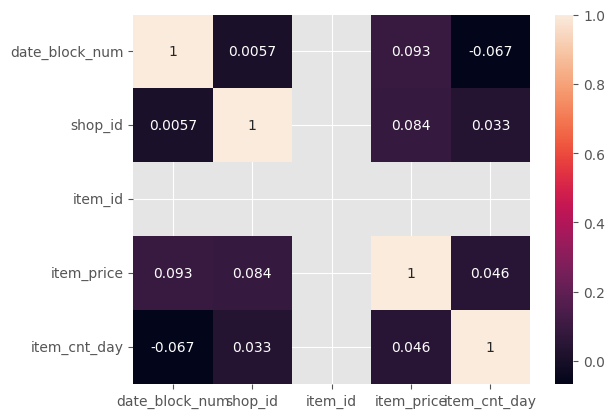

/var/folders/v5/19yl80b93g3cqcfgcwsk4h240000gn/T/ipykernel_5274/3694603694.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(sales_train_item20949["item_cnt_day"]).show()


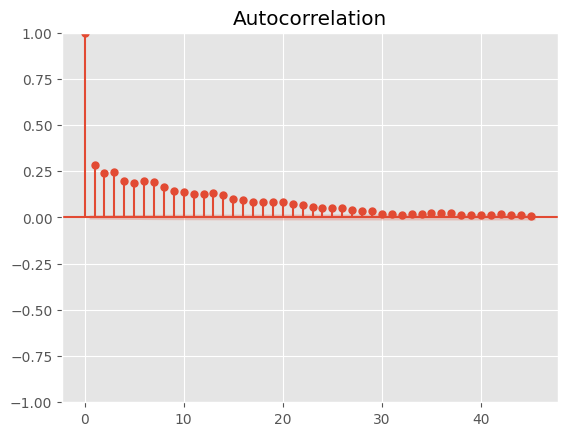

In [18]:
# use the cor function to look at the datasets, and then the acf function, with a lag 1.
# Plot the acf with different logs to see what happens.
sns.heatmap(sales_train_item20949.corr(), annot=True)
sales_train_item20949["item_cnt_day"].plot()
plt.show()
plot_acf(sales_train_item20949["item_cnt_day"]).show()

In [47]:
# Set index to date
sales_train_item20949 = sales_train_item20949.set_index("date")

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsm

                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                31340
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -119664.049
Date:                Mon, 03 Oct 2022   AIC                         239334.099
Time:                        15:28:34   BIC                         239359.157
Sample:                             0   HQIC                        239342.122
                              - 31340                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9873      0.135     44.484      0.000       5.723       6.251
ar.L1          0.2865      0.000    660.699      0.000       0.286       0.287
sigma2       121.3464      0.040   3021.859      0.0

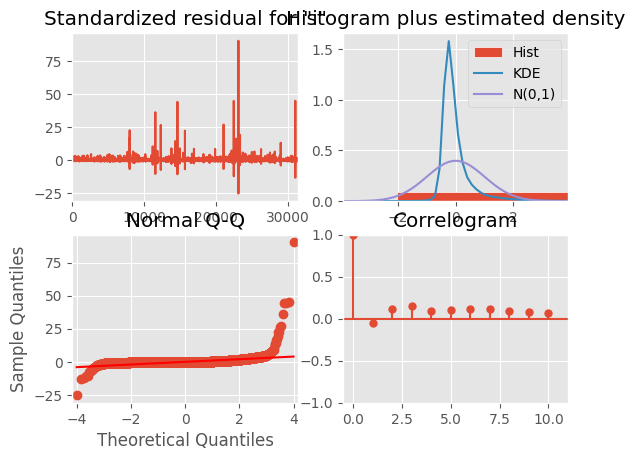

In [48]:
# Fit and plot an auto-regressive model to the time series.
model = ARIMA(sales_train_item20949["item_cnt_day"], order=(1, 0, 0))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics()
plt.show()

What are the intercept and the innovation variance (sigma2) estimate ?
What do these parameters mean ?

The intercept is the mean of the time series and the innovation variance is the variance of the error term.

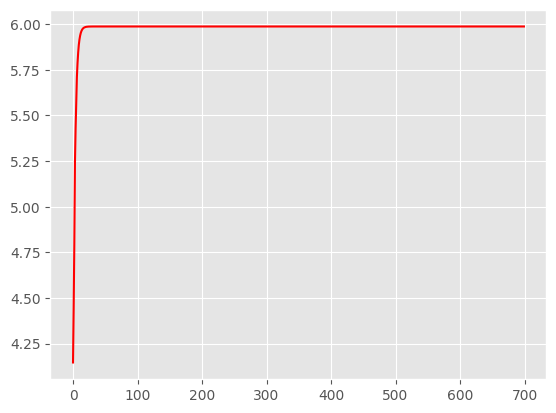

In [49]:
# Predict the sales for a month after the end of the training dataset.
# Use the predict function, and the forecast function.
# Plot the results.
X = sales_train_item20949["item_cnt_day"].values
ARIMA_model = ARIMA(X, order=(3, 0, 0))
ARIMA_model_fit = ARIMA_model.fit()
predictions = ARIMA_model_fit.forecast(steps=700)

plt.plot(predictions, color='red')
plt.show()

In [56]:
# Fit and plot a moving average model, and print the estimates
model = ARIMA(sales_train_item20949["item_cnt_day"], order=(0, 0, 1))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsm

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                31340
Model:                 ARIMA(0, 0, 1)   Log Likelihood             -120002.556
Date:                Mon, 03 Oct 2022   AIC                         240011.112
Time:                        15:36:13   BIC                         240036.170
Sample:                             0   HQIC                        240019.135
                              - 31340                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9873      0.114     52.558      0.000       5.764       6.211
ma.L1          0.2234      0.001    413.019      0.000       0.222       0.224
sigma2       123.9906      0.040   3067.576      0.000     123.911     124.070
===================================================================================
Ljung-Box (L1) (Q):                  41.16   Jarque-Bera (JB):        8195646736.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.21   Skew:                            35.64
Prob(H) (two-sided):                  0.00   Kurtosis:                      2507.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

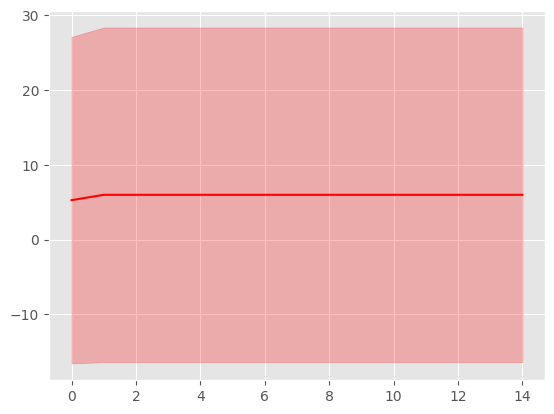

In [76]:
# Make a 1 to 15 steps forecast, and plot the 95 percent confidence intervals
X = sales_train_item20949["item_cnt_day"].values
ARIMA_model = ARIMA(X, order=(0, 0, 1))
ARIMA_model_fit = ARIMA_model.fit()
predictions = ARIMA_model_fit.get_forecast(steps=15)
confidence_interval = pd.DataFrame(predictions.conf_int(alpha = 0.05))

plt.plot(predictions.predicted_mean, color='red')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='red', alpha=.25)
plt.show()